# Intervalos de Confianza y Survival Analysis

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
from scipy import stats
from scipy.stats import chi2

## Preámbulo

### Estimación puntual

Consiste en dar **un solo valor** como estimador del parámetro. 

Por ejemplo, la media muestral $\bar{x}$ como estimador puntual de la media poblacional $ \mu $.  

Desventaja: no refleja la incertidumbre asociada a la estimación.  

### Estimación por regiones (intervalos)

En lugar de un único valor, se proporciona un **rango de valores plausibles** para el parámetro, con un cierto nivel de confianza.  
Ejemplo: un intervalo de confianza del 95% para $\mu$ podría ser:  
$$
[\bar{x} - 1.96 \cdot \tfrac{s}{\sqrt{n}}, \; \bar{x} + 1.96 \cdot \tfrac{s}{\sqrt{n}}]
$$

Desventaja: existen casos patológicos desde la interpretación frecuentista. 

## Intervalos de confianza

"Si repitiésemos el experimento muchas veces, aproximadamente el 95% de los IC construidos contendrían el valor verdadero del parámetro".

In [64]:
# Datos de ejemplo: alturas de 10 personas (en cm)
data = np.array([165, 170, 160, 175, 168, 172, 169, 174, 171, 166])

# Estimación puntual: media muestral
mean = np.mean(data)

# Error estándar de la media
se = stats.sem(data)  # sem = standard error of the mean

# Nivel de confianza
confidence = 0.95
alpha = 1 - confidence

# Valor crítico de la t de Student
t_crit = stats.t.ppf(1 - alpha/2, df=len(data)-1)

# Intervalo de confianza
ci_lower = mean - t_crit * se
ci_upper = mean + t_crit * se

print(f"Media muestral de alturas: {mean:.2f} cm")
print(f"Intervalo de confianza al 95%: ({ci_lower:.2f}, {ci_upper:.2f}) cm")


Media muestral de alturas: 169.00 cm
Intervalo de confianza al 95%: (165.78, 172.22) cm


¿Cómo llegamos a `mean` $\pm$ `t_crit * se`?

Se llega al límite inferior y superior de un intervalo de confianza usando un estimador puntual como centro y calculando su error estándar a partir de los datos.

Luego se multiplica el error estándar por el **valor crítico** de la distribución apropiada (t de Student, normal, etc.) para reflejar la incertidumbre bajo los supuestos sobre la distribución de los datos.


In [65]:
# Datos de ejemplo: tiempos hasta que la i-ésima maquina falle
data = np.array([5, 7, 3, 8, 6, 4, 9, 2, 7, 5])
n = len(data)
sum_data = np.sum(data)

# Intervalo de confianza exacto para la media (Exponencial)
ci_lower = 2 * sum_data / chi2.ppf(0.975, 2*n)
ci_upper = 2 * sum_data / chi2.ppf(0.025, 2*n)

mean_time = np.mean(data)

print(f"Media muestral: {mean_time:.2f} días")
print(f"IC 95% exacto para la media: ({ci_lower:.2f}, {ci_upper:.2f}) días")

Media muestral: 5.60 días
IC 95% exacto para la media: (3.28, 11.68) días


$$
\text{IC 95\% para la media de alturas: } 
IC_{95\%} = \bar{x} \pm t_{\alpha/2, n-1} \cdot \frac{s}{\sqrt{n}}
$$

$$
\text{IC 95\% para la tasa de una exponencial: } 
IC_{95\%}(\lambda) = \left[ \frac{2 \sum X_i}{\chi^2_{2n, 0.025}}, \; \frac{2 \sum X_i}{\chi^2_{2n, 0.975}} \right]
$$

## Survival Analysis

### Carga y limpieza de datos

In [37]:
data = pd.read_csv("http://theta.edu.pl/wp-content/uploads/2020/01/Aids2.csv", sep = ';')
data

,sex,diag,death,status,age,Unnamed: 5
0,M,1929-11-08,1930-05-03,D,35,NaN
1,M,1930-03-12,1930-05-18,D,53,NaN
2,M,1926-02-23,1927-05-01,D,42,NaN
3,M,1926-03-21,1926-06-06,D,44,NaN
4,M,1927-06-02,1928-03-03,D,39,NaN
...,...,...,...,...,...,...
2838,M,1931-06-01,1931-06-30,A,46,NaN
2839,F,1931-04-07,1931-06-30,A,34,NaN
2840,M,1931-06-22,1931-06-30,A,49,NaN
2841,M,1931-05-17,1931-06-30,A,55,NaN


In [38]:
data = data.drop(columns = ['Unnamed: 5'])
data.head()

,sex,diag,death,status,age
0,M,1929-11-08,1930-05-03,D,35
1,M,1930-03-12,1930-05-18,D,53
2,M,1926-02-23,1927-05-01,D,42
3,M,1926-03-21,1926-06-06,D,44
4,M,1927-06-02,1928-03-03,D,39


In [39]:
# He aquí la censura
data['status'].value_counts()

status
D    1761
A    1082
Name: count, dtype: int64

In [40]:
def to_date(row):
  row = datetime.strptime(row,'%Y-%m-%d')
  return row

def time_days(row):
  row = row.days
  return row

time = lambda x: x.death - x.diag
sex = lambda x: 1 if x.sex == 'M' else 0
status = lambda x: 1 if x.status == 'D' else 0

In [41]:
data.death = data.death.apply(to_date)
data.diag = data.diag.apply(to_date)
data['time'] = data.apply(time, axis=1)
data['sex'] = data.apply(sex, axis=1)
data['status'] = data.apply(status, axis=1)
data['time'] = data['time'].apply(time_days)

In [42]:
data

,sex,diag,death,status,age,time
0,1,1929-11-08,1930-05-03,1,35,176
1,1,1930-03-12,1930-05-18,1,53,67
2,1,1926-02-23,1927-05-01,1,42,432
3,1,1926-03-21,1926-06-06,1,44,77
4,1,1927-06-02,1928-03-03,1,39,275
...,...,...,...,...,...,...
2838,1,1931-06-01,1931-06-30,0,46,29
2839,0,1931-04-07,1931-06-30,0,34,84
2840,1,1931-06-22,1931-06-30,0,49,8
2841,1,1931-05-17,1931-06-30,0,55,44


In [43]:
data.describe()

,sex,diag,death,status,age,time
count,2843.000000,2843,2843,2843.000000,2843.000000,2843.000000
mean,0.968695,1928-12-22 07:57:38.177980928,1930-02-01 06:27:28.680970752,0.619416,37.409075,405.937390
min,0.000000,1922-09-23 00:00:00,1923-03-09 00:00:00,0.000000,0.000000,1.000000
25%,1.000000,1927-10-28 00:00:00,1929-03-19 12:00:00,0.000000,30.000000,128.000000
50%,1.000000,1929-03-13 00:00:00,1930-10-04 00:00:00,1.000000,37.000000,320.000000
75%,1.000000,1930-05-25 00:00:00,1931-06-30 00:00:00,1.000000,43.000000,583.000000
max,1.000000,1931-06-29 00:00:00,1931-06-30 00:00:00,1.000000,82.000000,2470.000000
std,0.174171,NaN,NaN,0.485616,10.063263,363.926581


In [ ]:
# Filtremos los datos para quedarse solo con los primeros 2 años (máximo 730 días) de terapia.
# (Censuramos a la derecha cualquier tiempo mayor a 2 años, para evitar que datos largos distorsionen los modelos).
data['time2'] = data['time']
data.loc[data['time2'] > 730, 'time2'] = 730

data['status2'] = data['status']
data.loc[(data['time'] > 730) & (data['status'] == 1), 'status2'] = 0

data

,sex,diag,death,status,age,time,time2,status2
0,1,1929-11-08,1930-05-03,1,35,176,176,1
1,1,1930-03-12,1930-05-18,1,53,67,67,1
2,1,1926-02-23,1927-05-01,1,42,432,432,1
3,1,1926-03-21,1926-06-06,1,44,77,77,1
4,1,1927-06-02,1928-03-03,1,39,275,275,1
...,...,...,...,...,...,...,...,...
2838,1,1931-06-01,1931-06-30,0,46,29,29,0
2839,0,1931-04-07,1931-06-30,0,34,84,84,0
2840,1,1931-06-22,1931-06-30,0,49,8,8,0
2841,1,1931-05-17,1931-06-30,0,55,44,44,0


### Distribución Weibull

La distribución de Weibull (continua) se usa ampliamente en **análisis de supervivencia y confiabilidad** (tiempos de vida, fallas de sistemas, mantenimiento preventivo).

$$
f(t; \rho, \lambda) = \frac{\rho}{\lambda} \left(\frac{t}{\lambda}\right)^{\rho-1} 
\exp\!\left[-\left(\frac{t}{\lambda}\right)^\rho\right], \quad t \geq 0
$$

- $\rho$ (**forma**): controla la tasa de fallo.  
  - $\rho < 1$: fallas tempranas (riesgo decreciente).  
  - $\rho = 1$: riesgo constante (distribución exponencial).  
  - $\rho > 1$: desgaste progresivo (riesgo creciente).  

- $\lambda$ (**escala**): estira o comprime la distribución en el tiempo.  

**Función de supervivencia**

$$
S(t) = \exp\!\left[-\left(\frac{t}{\lambda}\right)^\rho\right]
$$


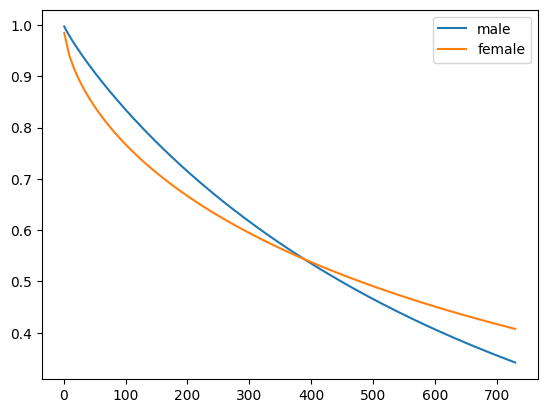

In [ ]:
from lifelines import WeibullFitter

wb = WeibullFitter()

male = (data["sex"]==1)
female = (data["sex"]==0)
ax = plt.subplot(111)

wb.fit(data[male]["time2"],data[male]["status2"],label="male")
wb.survival_function_.plot(ax=ax)

wb.fit(data[female]["time2"],data[female]["status2"],label="female")
wb.survival_function_.plot(ax=ax)

plt.show()

In [ ]:
# Parámetros estimados
print(wb.lambda_, wb.rho_)

870.5870888639881 0.6142470950650616


In [57]:
# Predicción de la supervivencia en t, es decir, la probabilidad de que el evento aún no haya ocurrido a los 20 unidades de tiempo
print(wb.predict(20))

0.906206678072434


### QQ plots

Un **QQ-plot** (*Quantile-Quantile plot*) es una herramienta gráfica que compara los **cuantiles de una muestra de datos** con los **cuantiles de una distribución teórica** o de un modelo ajustado.  

**Interpretación**
- Si los puntos caen aproximadamente sobre la línea recta de 45° ($y=x$), los datos son consistentes con la distribución encontrada.
- Desviaciones sistemáticas indican que la distribución encontrada no describe bien los datos.

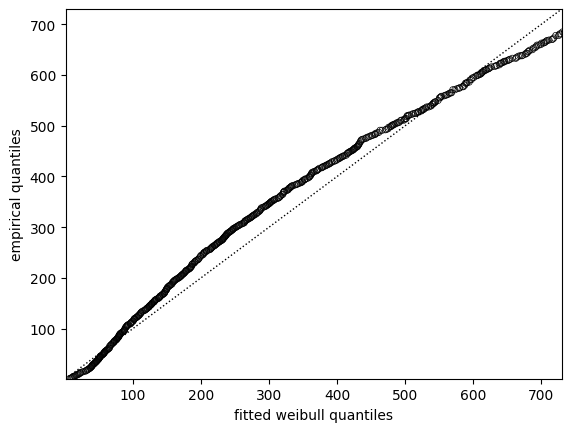

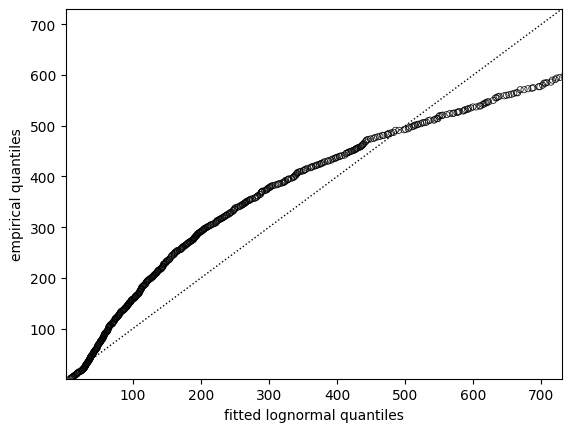

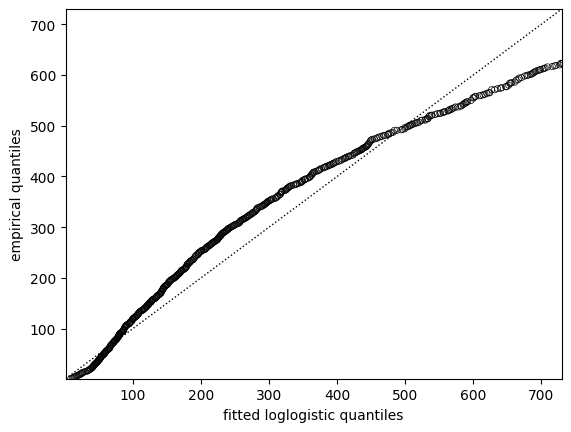

In [58]:
from lifelines.plotting import qq_plot 
from lifelines import WeibullFitter, LogNormalFitter, LogLogisticFitter

for model in [WeibullFitter(),
              LogNormalFitter(),
              LogLogisticFitter()]:
  model.fit(data["time2"], data["status2"])
  model.plot_survival_function(ax = ax)
  qq_plot(model)
  plt.show()